In [176]:
from datetime import datetime

import numpy as np
import torch
import torch.nn.functional as F
import torch_geometric.nn as nng
import torch.nn as nn

import util

from Dimploma.EnvironmentTree import EnvMinimalTree, EnvMinimalTreeTwoStep
from Dimploma.ppo_parallel_custom import Agent
from Dimploma.utils.graph_provider import GraphProvider
from torch_geometric.data import Data

In [158]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [177]:
class GCN(torch.nn.Module):
    def __init__(self, out_size, num_node_features):
        super().__init__()
        self.out_size = out_size
        self.conv1 = nng.GATConv(num_node_features, 16)
        self.conv2 = nng.GATConv(16, 16)
        # self.conv3 = GCNConv(16, 16)
        # self.conv4 = GCNConv(16, 16)

        self.conv_p1 = nng.GATConv(16, 16)
        self.conv_p2 = nng.GATConv(16, 1)
        # self.fc_p1 = nn.Linear(16, 16)
        # self.fc_p2 = nn.Linear(16, graph_t.num_nodes)
        # self.fc_p2 = nn.Linear(16, 1)

        self.fc_v1 = nn.Linear(16, 16)
        self.fc_v2 = nn.Linear(16, 1)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_normal_(module.weight)
            torch.nn.init.zeros_(module.bias)

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_attr[:, :2] # take only the normalized distances with edge_attr[:, 0]
        # print(data.num_node_features)
        # print(f'x start: {x.shape}')
        # print(f'Edge index start: {edge_index.shape}')
        # print(f'Edge index start: {edge_weight}')

        x = F.relu(self.conv1(x, edge_index, edge_weight))
        # print(f'Edge index after conv1: {edge_weight}')
        # print(f'x conv1: {x.shape}')
        # print(f'Edge index conv1: {edge_index.shape}')
        # x = F.dropout(x, training=self.training)
        x = F.relu(self.conv2(x, edge_index, edge_weight))
        # print(f'Edge index after conv2: {edge_weight}')
        # print(f'x conv2: {x.shape}')
        # print(f'Edge index conv2: {edge_index.shape}')

        # x = F.sigmoid(self.conv3(x, edge_index, edge_weight))
        # # print(f'Edge index after conv3: {edge_weight}')
        # # print(f'x conv3: {x.shape}')
        # x = F.sigmoid(self.conv4(x, edge_index, edge_weight))
        # print(f'Edge index after conv4: {edge_weight}')
        
        px = F.relu(self.conv_p1(x, edge_index, edge_weight))
        # print(f'x convp1: {x.shape}')
        px = self.conv_p2(px, edge_index, edge_weight)
        # print(f'x convp2: {x.shape}')

        px = px.view(-1, min(self.out_size, px.shape[0]))
        # X = X.view(-1, self.node_count)
        
        x = x.unsqueeze(0)
        x = x.view(-1, min(self.out_size, x.shape[1]), self.conv1.out_channels)
        v = x.mean(dim=1)
        v = F.relu(self.fc_v1(v))
        # print(f'v fcv1: {v.shape}')
        vx = self.fc_v2(v)

        # print(f'x result: {X.shape}')
        # print(f'v result: {V.shape}')
        # print(f'Edge index end: {edge_weight}')
        return px, vx

device:  cpu


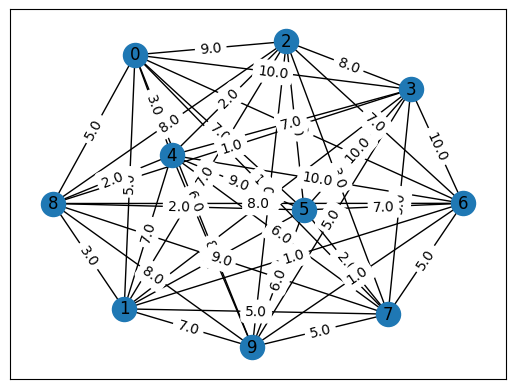

Name: n10_e45_+2_4Gats
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2,
         3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 7, 7, 8],
        [1, 2, 3, 4, 5, 6, 7, 8, 9, 2, 3, 4, 5, 6, 7, 8, 9, 3, 4, 5, 6, 7, 8, 9,
         4, 5, 6, 7, 8, 9, 5, 6, 7, 8, 9, 6, 7, 8, 9, 7, 8, 9, 8, 9, 9]]) tensor([[ 5.,  0.],
        [ 9.,  0.],
        [10.,  0.],
        [ 3.,  0.],
        [ 7.,  0.],
        [ 7.,  0.],
        [ 1.,  0.],
        [ 5.,  0.],
        [ 6.,  0.],
        [ 7.,  0.],
        [ 1.,  0.],
        [ 7.,  0.],
        [ 5.,  0.],
        [ 1.,  0.],
        [ 5.,  0.],
        [ 3.,  0.],
        [ 7.,  0.],
        [ 8.,  0.],
        [ 2.,  0.],
        [ 5.,  0.],
        [ 7.,  0.],
        [ 3.,  0.],
        [ 8.,  0.],
        [ 5.,  0.],
        [ 7.,  0.],
        [10.,  0.],
        [10.,  0.],
        [ 5.,  0.],
        [ 1.,  0.],
        [ 5.,  0.],
        [ 9.,  0.],
        [10.,  0.],
        [ 6.,  0.],
        

In [178]:
node_amount = 10
edge_amount = 45
iteration_amount = 500
epoch_amount = 10
batch_size = 64
node_features = 2  # (index, {0,1} selected or not)
steps_amount = int((node_amount - 1)*2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device: ', device)

fixed_graph = True
node_env = True
graph = None

if fixed_graph:
    graph = util.generate_random_graph(node_amount, edge_amount, device=device)
    util.show_data(graph)

graph_provider = GraphProvider(fixed_graph=graph, device=device, nodes=node_amount, edges=edge_amount)


name = f'n{node_amount}_e{edge_amount}_+2_4Gats'
path = 'results/min_tree_ppo/node/'
last_path = f'models/iter_{iteration_amount - 1}_last.pt'
print("Name:", name)
if fixed_graph:
    print(graph.edge_index, graph.edge_attr, graph.x)

In [165]:
last_name = "fuckup"

In [179]:
start_date = datetime.now()

try:
    # noinspection PyUnresolvedReferences
    if last_name == name:
        raise Exception("You should change the name :D")
except NameError:
    raise Exception("You should init last name :D")

last_name = name

net = GCN(node_amount if node_env else edge_amount, node_features)

print(f'Agent {name}')

agent = Agent(model=net, device=device, path=path, name=name, override=True)


# agent.train([device, None, node_amount, edge_amount], EnvMinimalTreeTwoStep if node_env else EnvMinimalTree, node_amount, count_of_processes=1, count_of_envs=1, batch_size=32, count_of_iterations=iteration_amount)
agent.train([graph_provider], EnvMinimalTreeTwoStep if node_env else EnvMinimalTree, node_amount, count_of_iterations=iteration_amount, count_of_epochs=epoch_amount, batch_size=batch_size, count_of_steps=steps_amount)


end_date = datetime.now()
s = (end_date - start_date).seconds
hours, remainder = divmod(s, 3600)
minutes, seconds = divmod(remainder, 60)
print(f'Time training {int(hours):02}:{int(minutes):02}:{int(seconds):02}')

Agent n10_e45_+2_4Gats
Training is starting
Iteration 0 starting
Iteration 0	episode 32	avg score -2.03606	best score -1.00000	best avg score -2.03606
Iteration 1 starting
Iteration 1	episode 64	avg score -1.93389	best score -0.76923	best avg score -1.93389
Iteration 2 starting
Iteration 2	episode 96	avg score -1.90385	best score -0.76923	best avg score -1.90385
Iteration 3 starting
Iteration 3	episode 128	avg score -1.81538	best score -0.69231	best avg score -1.81538
Iteration 4 starting
Iteration 4	episode 160	avg score -1.78231	best score -0.53846	best avg score -1.78231
Iteration 5 starting
Iteration 5	episode 192	avg score -1.80538	best score -0.53846	best avg score -1.78231
Iteration 6 starting
Iteration 6	episode 224	avg score -1.78846	best score -0.53846	best avg score -1.78231
Iteration 7 starting
Iteration 7	episode 256	avg score -1.81538	best score -0.30769	best avg score -1.78231
Iteration 8 starting
Iteration 8	episode 288	avg score -1.90154	best score -0.30769	best avg sc

In [167]:
test_amount = 100

In [116]:
# graph_test = util.generate_random_graph(node_amount, edge_amount)
graph_test = graph

In [180]:

test_env = EnvMinimalTreeTwoStep(graph_provider)

net_test = GCN(node_amount if node_env else edge_amount, node_features)
agent_test = Agent(model=net_test, device=device, name=name + "_test", override=True, test=True)

agent_test.load_model(f"{agent.path}{last_path}")



Loading model from results/min_tree_ppo/node/241122_18#n10_e45_+2_4Gats/models/iter_499_last.pt


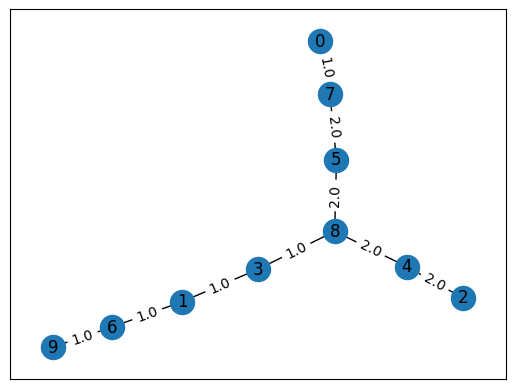

In [181]:
util.show_data(test_env.min_tree)

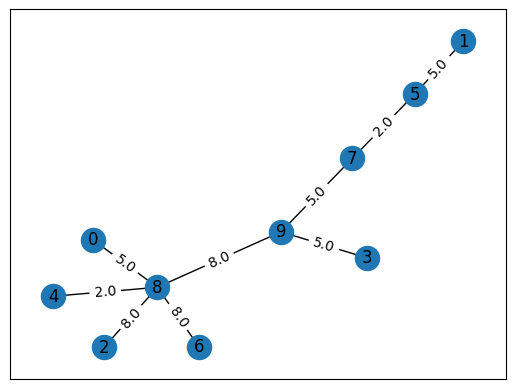

(tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
         1., 0., 0., 0., 1., 0., 0., 1., 1.]),
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1.6923076923076925],
 [9, 7, 9, 8, 7, 5, 5, 1, 8, 6, 9, 3, 4, 8, 8, 2, 8, 0])

In [192]:
_ ,a, b, c = agent_test.test(test_env)

test_env.show_selected_tree()

# mask = torch.argwhere(graph_test.edge_attr[:, 1] == 1)[:, 0]
# sel_graph = Data(x=graph_test.x, edge_index=graph_test.edge_index[:, mask], edge_weight=graph_test.edge_weight[mask])
# sel_graph_g = util.my_to_networkx(sel_graph)
# util.show_data(sel_graph)
a,b,c